This notebook explores the effect of binning on accuracy of metrics, e.g. mean

In [1]:
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [147]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 14

In [148]:
from scipy.stats import beta

We'll use a beta function https://en.wikipedia.org/wiki/Beta_distribution as our reference distribution, as it is nicely bound in [0, 1], and is easy to change its shape a little (akin to detector vs unfolded).

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html#scipy.stats.beta

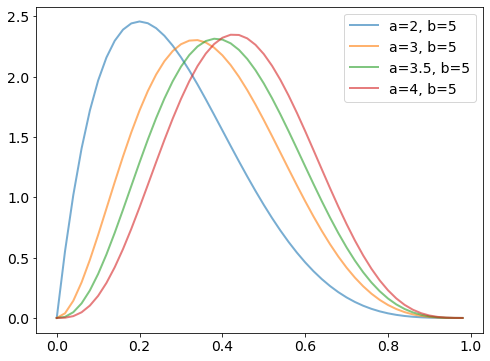

In [286]:
# let's see what parameter a does
x = np.arange(0, 1, 0.02)
for a in [2, 3, 3.5, 4]:
    b = 5
    plt.plot(x, beta.pdf(x, a, b), lw=2, alpha=0.6, label=f'a={a}, b={b}')
    plt.legend();

Larger a -> shifts distribution to larger x values

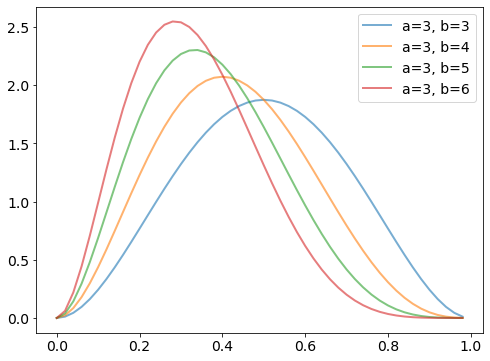

In [289]:
# let's see what parameter b does
for b in [3, 4, 5, 6]:
    a = 3
    plt.plot(x, beta.pdf(x, a, b), lw=2, alpha=0.6, label=f'a={a}, b={b}')
    plt.legend();

Larger b -> shifts distributions to smaller x

With this, we can approximate our true data with similar shapes

In [269]:
# parameters for our "true" underlying model. a~3 is more like Z+jets, a~4 is more like dijet
detector_a, detector_b = 3.1, 5
unfolded_a, unfolded_b = 3., 5

In [270]:
# sample models to create datasets
detector_data = beta.rvs(detector_a, detector_b, size=int(1E6)) # enough data points to minimise sampling uncert
unfolded_data = beta.rvs(unfolded_a, unfolded_b, size=int(1E6))

In [ ]:
def construct_fine_binning(coarse_bin_edges):
    fine_bin_edges = []
    for x, y in zip(coarse_bin_edges[:-1], coarse_bin_edges[1:]):
        fine_bin_edges.append(x)
        fine_bin_edges.append(0.5*(x+y))
    fine_bin_edges.append(coarse_bin_edges[-1])
    return np.array(fine_bin_edges, dtype='d')

In [380]:
binning = np.array([0.0, 0.17, 0.25, 0.32, 0.38, 0.45, 0.52, 0.59, 0.66, 1.0], dtype='d')
# binning = construct_fine_binning(binning)

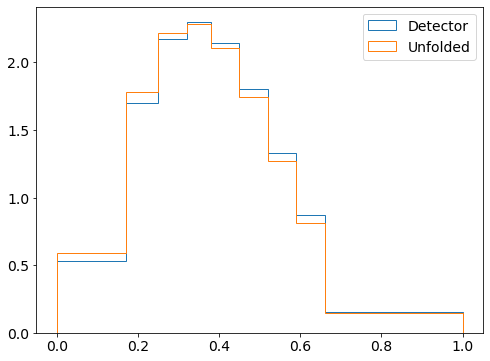

In [381]:
fig, ax = plt.subplots(1, 1)
detector_n, bins, _ = ax.hist(detector_data, bins=binning, histtype='step', label='Detector', density=True)
unfolded_n, _, _ = ax.hist(unfolded_data, bins=binning, histtype='step', label='Unfolded', density=True)
plt.legend();

In [412]:
# true means, if we had every measurment
detector_mean_true = np.mean(detector_data)
unfolded_mean_true = np.mean(unfolded_data)

In [383]:
# calculate "dumb" mean using only bin areas and bin centers
def calc_mean(bin_areas, bin_centers):
    return np.sum(bin_areas * bin_centers) / np.sum(bin_areas)

In [384]:
centers = 0.5*(binning[:-1] + binning[1:])

In [385]:
centers

array([0.085, 0.21 , 0.285, 0.35 , 0.415, 0.485, 0.555, 0.625, 0.83 ])

In [386]:
widths = np.diff(binning)

In [387]:
widths

array([0.17, 0.08, 0.07, 0.06, 0.07, 0.07, 0.07, 0.07, 0.34])

In [388]:
detector_areas = detector_n * widths # convert density to area
detector_mean_binned = calc_mean(detector_areas, centers)

In [389]:
unfolded_areas = unfolded_n * widths # convert density to area
unfolded_mean_binned = calc_mean(unfolded_areas, centers)

In [390]:
detector_rel_diff = (detector_mean_true - detector_mean_binned) / detector_mean_true
unfolded_rel_diff = (unfolded_mean_true - unfolded_mean_binned) / unfolded_mean_true

In [391]:
print(f"Detector true mean: {detector_mean_true:.4g} vs binned mean: {detector_mean_binned:.4g} = {100*detector_rel_diff:.4g}% diff")
print(f"Unfolded true mean: {unfolded_mean_true:.4g} vs binned mean: {unfolded_mean_binned:.4g} = {100*unfolded_rel_diff:.4g}% diff")

Detector true mean: 0.3829 vs binned mean: 0.3853 = -0.6172% diff
Unfolded true mean: 0.3752 vs binned mean: 0.377 = -0.481% diff


So it looks like there is about a 0.5% (for a ~ 3) to 2% (for a ~ 4) error incurred from our binning scheme.

Note that if we use the detector-level binning (half-width), it goes down to 0.2-0.5%

However, the shift is approximately the same for both detector & unfolded, and in the same direction. So the difference betweem the two remains similar

In [411]:
# mathematical mean to double check our "true" mean
print(beta.stats(detector_a, detector_b, moments='m'))
print(beta.stats(unfolded_a, unfolded_b, moments='m'))

0.3827160493827161
0.375


We can do a general function to calculate both true & binned means for any a, b, and binning scheme

In [393]:
def calculate_means(a, b, binning):
    data = beta.rvs(a, b, size=int(1E6))
    true_mean = data.mean()
    centers = 0.5*(binning[:-1] + binning[1:])
    widths = np.diff(binning)
    densities, _ = np.histogram(data, bins=binning, density=True)
    areas = densities * widths
    binned_mean = calc_mean(areas, centers)
    return true_mean, binned_mean

In [394]:
calculate_means(3, 5, binning)

(0.375082278685783, 0.376812145)

In [395]:
calculate_means(4, 5, binning)

(0.44446629566551893, 0.45247188)

In [413]:
a_values = np.arange(1, 8, 0.25)
value_data = np.array([calculate_means(a, 5, binning) for a in a_values])

In [414]:
value_data.shape

(28, 2)

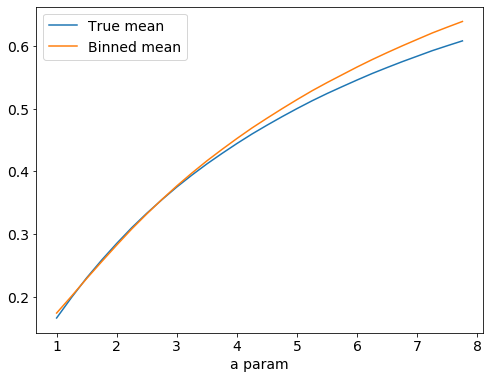

In [415]:
plt.plot(a_values, value_data[:,0], label='True mean')
plt.plot(a_values, value_data[:,1], label='Binned mean')
plt.legend();
plt.xlabel('a param');

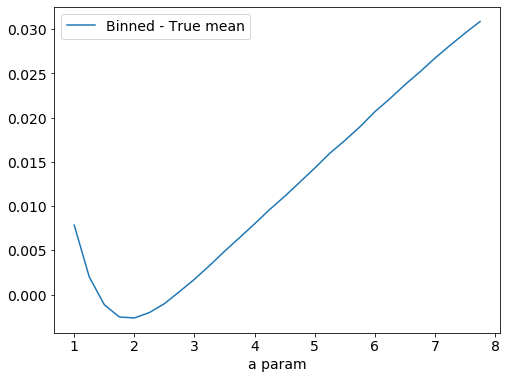

In [416]:
plt.plot(a_values, value_data[:,1]-value_data[:,0], label='Binned - True mean')
plt.legend();
plt.xlabel('a param');

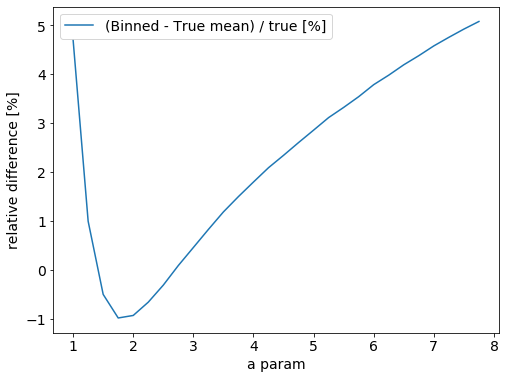

In [417]:
plt.plot(a_values, 100*((value_data[:,1]-value_data[:,0]) / value_data[:,0]), label='(Binned - True mean) / true [%]')
plt.legend();
plt.xlabel('a param');
plt.ylabel('relative difference [%]');